# Playing with BigQuery ML
This tutorial introduces data analysts to BigQuery ML. BigQuery ML enables users to create and execute machine learning models in BigQuery using SQL queries. The goal is to democratize machine learning by enabling SQL practitioners to build models using their existing tools and to increase development speed by eliminating the need for data movement.

In this tutorial, you use the natality sample table to create a model that predicts the birth weight of a child based on the baby’s gender, the length of the pregnancy, and demographic information about the mother. The natality sample table contains information about every birth in the United States over a 40 year period.

## Setup
Check the quickstart for datalab on how setup a datalab vm in a region near you. After connecting to datalab (port 8081) upload this notebook. 

## Sampling the natality dataset

In [1]:
%%bq sample --table publicdata.samples.natality --count 5

source_year,year,month,day,wday,state,is_male,child_race,weight_pounds,plurality,apgar_1min,apgar_5min,mother_residence_state,mother_race,mother_age,gestation_weeks,lmp,mother_married,mother_birth_state,cigarette_use,cigarettes_per_day,alcohol_use,drinks_per_week,weight_gain_pounds,born_alive_alive,born_alive_dead,born_dead,ever_born,father_race,father_age,record_weight
1969,1969,3,12,,OR,True,1,8.12623897732,,,,OR,1,28,99,99991998,True,,,,,,,3,1,1,6,1,29,2
1969,1969,12,22,,PA,False,1,8.37536133338,,,,PA,1,18,,88881998,True,,,,,,,1,0,0,2,1,20,2
1970,1970,9,18,,GA,False,1,7.43839671988,,,,GA,1,18,,88881908,,GA,,,,,,0,0,0,1,1,21,2
1970,1970,6,24,,HI,True,6,6.87621795178,,,,HI,6,26,44,08171999,True,MN,,,,,,2,0,0,3,7,28,2
1970,1970,2,12,,NM,True,1,8.00057548798,,,,NM,1,24,,88881908,,CO,,,,,,3,0,0,4,9,99,2


## Saving the query

In [3]:
%%bq query --name natality 
SELECT wday, SUM(record_weight) c
FROM `publicdata.samples.natality`
GROUP BY wday
HAVING wday > 0
ORDER BY wday

## Running the query

In [4]:
%%bq query
SELECT wday, SUM(record_weight) c
FROM `publicdata.samples.natality`
GROUP BY wday
HAVING wday > 0
ORDER BY wday

wday,c
1,8386932
2,11926951
3,13139372
4,12926511
5,12867449
6,12742220
7,9292002


## Charting the result

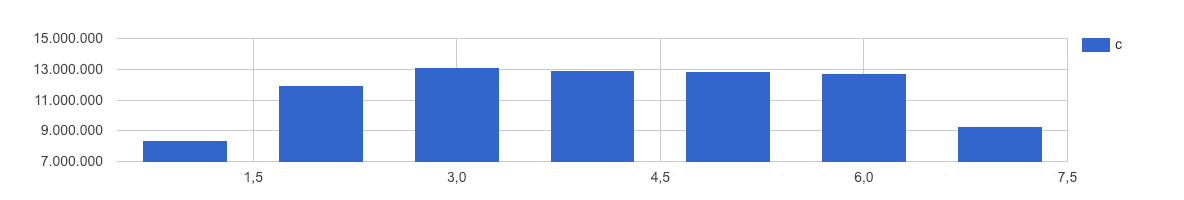

In [5]:
%chart columns --data natality --fields wday,c

## Let's delete and create a dataset to save the model

In [6]:
%%bq datasets delete -n bqml

Failed to delete dataset bqml: Cannot delete non-existent dataset funwithcloud.bqml


In [7]:
%bq datasets create -n bqml

## Create the model

A model in BigQuery ML represents what an ML system has learned from the training data.

The following types of models are supported by BigQuery ML:

Linear regression for forecasting — for example, the sales of an item on a given day. Labels are real-valued (they cannot be +/- infinity or NaN).
Binary logistic regression for classification — for example, determining whether a customer will make a purchase. Labels must only have two possible values.
Multiclass logistic regression for classification — These models can be used to predict multiple possible values such as whether an input is "low-value", "medium-value", or "high-value". Labels can have up to 50 unique values. In BigQuery ML, multiclass logistic regression training uses a multinomial classifier with a cross entropy loss function.
In BigQuery ML, a model can be used with data from multiple BigQuery datasets for training and for prediction.

When you create a model, categorical variables (of type BOOL, STRING, BYTES, DATE, DATETIME, or TIME) are one-hot encoded by default during training and prediction.

TIMESTAMP is not currently one-hot encoded by default. Use the CAST function to cast TIMESTAMP columns to STRING so that BigQuery ML treats the column as categorical.

For one-hot encoded features, each column value is an array of structs in the following format: [<String_Value, Weight>]. The length of the array is the cardinality (number of values) of that feature. A feature is an input variable used to make a prediction.

Numerical variables (of type NUMERIC, FLOAT64 or INT64) are standardized by default. In addition, standardization is automatically applied during prediction.

In [8]:
%%bq query
#standardSQL
CREATE MODEL `bqml.natality_model`
OPTIONS
  (model_type='linear_reg',
    input_label_cols=['weight_pounds']) AS
SELECT
  weight_pounds,
  is_male,
  gestation_weeks,
  mother_age,
  CAST(mother_race AS string) AS mother_race
FROM
  `publicdata.samples.natality`
WHERE
  weight_pounds IS NOT NULL
  AND RAND() < 0.001

QueryResultsTable job_L1ZZ937Pww-PnBj22Wvf22e0UTNH

## Evaluate the Model

In [9]:
%%bq query
#standardSQL
SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml.natality_model`,
    (
    SELECT
      weight_pounds,
      is_male,
      gestation_weeks,
      mother_age,
      CAST(mother_race AS STRING) AS mother_race
    FROM
      `bigquery-public-data.samples.natality`
    WHERE
      weight_pounds IS NOT NULL))

mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0.95627043831,1.67565457031,0.034263170549,0.737791556289,0.046495163128,0.0464953611266


## Use the Model

In [10]:
%%bq query 
#standardSQL
SELECT
  predicted_weight_pounds
FROM
  ML.PREDICT(MODEL `bqml.natality_model`,
    (
    SELECT
      is_male,
      gestation_weeks,
      mother_age,
      CAST(mother_race AS STRING) AS mother_race
    FROM
      `bigquery-public-data.samples.natality`
    WHERE
      state = "WY"))

predicted_weight_pounds
7.74399294439
7.7003608276
7.3315079601
7.40661545341
7.76617017807
7.42235314167
7.42378244038
7.40017590798
7.64885986669
7.53823415435
